In [1]:
import pandas as pd
import numpy as np
import os
import sumolib
import random
from tqdm import tqdm
from datetime import datetime

In [2]:
# plan_original = pd.read_csv('../../Data/tables/plan_original.csv', index_col=0)
# plan_original_ = plan_original[plan_original.start_hour==0]
# # plan_original_ = plan_original_[plan_original_.inter_no.isin([175, 210])]
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#     display(plan_original_) # overlap : 175, 201, 210

# 1. 이동류 매칭

In [3]:
# [이동류번호] 불러오기
path_moves = '../../Data/tables/movements/'
csv_moves = os.listdir('../../Data/tables/movements/')
moves = [pd.read_csv(path_moves + csv_movement, index_col=0) for csv_movement in tqdm(csv_moves)]
match1 = pd.concat(moves).drop_duplicates().sort_values(by=['inter_no','phas_A','phas_B']).reset_index(drop=True)
match1 = match1[match1.inter_no!=212]
match1.head(10)

100%|██████████| 17280/17280 [00:13<00:00, 1309.86it/s]


inter_no  phas_A  phas_B  move_A  move_B
0       175       1       1       8       4
1       175       2       2       7       3
2       175       3       3       6       1
3       175       3       4       6       2
4       175       4       4       5       2
5       176       1       1       8       4
6       176       2       2       8       3
7       176       3       3       5      18
8       177       1       1       8       4
9       177       2       2       7       3

In [4]:
# 계층화
moveA = match1[['inter_no', 'phas_A', 'move_A']].copy()
moveA.columns = ['inter_no', 'phase_no', 'move_no']
moveA['ring_type'] = 'A'
moveB = match1[['inter_no', 'phas_B', 'move_B']].copy()
moveB.columns = ['inter_no', 'phase_no', 'move_no']
moveB['ring_type'] = 'B'
match2 = pd.concat([moveA, moveB]).drop_duplicates()
match2 = match2[['inter_no', 'phase_no', 'ring_type', 'move_no']]
match2 = match2.sort_values(by=list(match2.columns))
match2.head(10)

inter_no  phase_no ring_type  move_no
0       175         1         A        8
0       175         1         B        4
1       175         2         A        7
1       175         2         B        3
2       175         3         A        6
2       175         3         B        1
4       175         4         A        5
3       175         4         B        2
5       176         1         A        8
5       176         1         B        4

In [5]:
# [nema 이동류목록] 불러오기 및 병합
nema = pd.read_csv('../../Data/tables/nema.csv', encoding='cp949')
match3 = pd.merge(match2, nema, how='left', left_on='move_no', right_on='이동류번호').drop_duplicates()
match3.rename(columns={'진입방향': 'inc_dir', '진출방향': 'out_dir'}, inplace=True)
match3.drop('이동류번호', axis=1, inplace=True)
match3

inter_no  phase_no ring_type  move_no inc_dir out_dir
0        175         1         A        8       남       북
1        175         1         B        4       북       남
2        175         2         A        7       북       동
3        175         2         B        3       남       서
4        175         3         A        6       동       서
..       ...       ...       ...      ...     ...     ...
59       210         4         B        3       남       서
60       211         1         A        6       동       서
61       211         1         B        2       서       동
62       211         2         A       17     NaN     NaN
63       211         2         B       18     NaN     NaN

[64 rows x 6 columns]

In [6]:
# [방위각정보] 불러오기 및 병합
angle = pd.read_csv('../../Data/tables/angle.csv', index_col=0)
six_chars = angle.angle_code.apply(lambda x:len(x)==6)
angle.loc[six_chars,'inc_angle'] = angle.angle_code.apply(lambda x:x[:3])
angle.loc[six_chars,'out_angle'] = angle.angle_code.apply(lambda x:x[3:])
angle = angle.drop('angle_code', axis=1)
match4 = pd.merge(match3, angle, how='left', left_on=['inter_no', 'phase_no', 'ring_type'],
                 right_on=['inter_no', 'phase_no', 'ring_type']).drop_duplicates()
match4

inter_no  phase_no ring_type  move_no inc_dir out_dir inc_angle out_angle
0        175         1         A        8       남       북       179       004
1        175         1         B        4       북       남       NaN       NaN
2        175         2         A        7       북       동       NaN       NaN
3        175         2         B        3       남       서       179       270
4        175         3         A        6       동       서       NaN       NaN
..       ...       ...       ...      ...     ...     ...       ...       ...
59       210         4         B        3       남       서       180       270
60       211         1         A        6       동       서       NaN       NaN
61       211         1         B        2       서       동       270       090
62       211         2         A       17     NaN     NaN       NaN       NaN
63       211         2         B       18     NaN     NaN       NaN       NaN

[64 rows x 8 columns]

In [7]:
# [네트워크], [교차로-노드 매칭], [교차로정보] 불러오기 
net = sumolib.net.readNet('../../Data/networks/SN_sample.net.xml')
inter_node = pd.read_csv('../../Data/tables/inter_node.csv', index_col=0)
inter_info = pd.read_csv('../../Data/tables/inter_info.csv', index_col=0)

inter_node1 = inter_node[inter_node.inter_type == 'parent'].drop('inter_type', axis=1)
inter_info1 = inter_info[['inter_no', 'inter_lat', 'inter_lon']]
inter = pd.merge(inter_node1, inter_info1, how='left', left_on=['inter_no'],
                 right_on=['inter_no']).drop_duplicates()

inter2node = dict(zip(inter['inter_no'], inter['node_id']))

match5 = match4.copy()
# 진입진출ID 매칭
for index, row in match5.iterrows():
    node_id = inter2node[row.inter_no]
    node = net.getNode(node_id)
    # 교차로의 모든 (from / to) edges
    inc_edges = [edge for edge in node.getIncoming() if edge.getFunction() == ''] # incoming edges
    out_edges = [edge for edge in node.getOutgoing() if edge.getFunction() == ''] # outgoing edges
    # 교차로의 모든 (from / to) directions
    inc_dirs = []
    for inc_edge in inc_edges:
        start = inc_edge.getShape()[-2]
        end = inc_edge.getShape()[-1]
        inc_dir = np.array(end) - np.array(start)
        inc_dir = inc_dir / (inc_dir ** 2).sum() ** 0.5
        inc_dirs.append(inc_dir)
    out_dirs = []
    for out_edge in out_edges:
        start = out_edge.getShape()[0]
        end = out_edge.getShape()[1]
        out_dir = np.array(end) - np.array(start)
        out_dir = out_dir / (out_dir ** 2).sum() ** 0.5
        out_dirs.append(out_dir)
    # 진입각, 진출각 불러오기
    if not pd.isna(row.inc_angle):
        inc_angle = int(row.inc_angle)
        out_angle = int(row.out_angle)
        # 방위각을 일반각으로 가공, 라디안 변환, 단위벡터로 변환
        inc_angle = (-90 - inc_angle) % 360
        inc_angle = inc_angle * np.pi / 180.
        inc_dir_true = np.array([np.cos(inc_angle), np.sin(inc_angle)])
        out_angle = (90 - out_angle) % 360
        out_angle = out_angle * np.pi / 180.
        out_dir_true = np.array([np.cos(out_angle), np.sin(out_angle)])
        # 매칭 엣지 반환
        inc_index = np.array([np.dot(inc_dir, inc_dir_true) for inc_dir in inc_dirs]).argmax()
        out_index = np.array([np.dot(out_dir, out_dir_true) for out_dir in out_dirs]).argmax()
        inc_edge_id = inc_edges[inc_index].getID()
        out_edge_id   = out_edges[out_index].getID()
        match5.at[index, 'inc_edge'] = inc_edge_id
        match5.at[index, 'out_edge'] = out_edge_id
match5['node_id'] = match5['inter_no'].map(inter2node)
match5 = match5[['inter_no', 'node_id', 'move_no', 'inc_edge', 'out_edge']]
match5 = match5.sort_values(by=['inter_no', 'move_no']).reset_index(drop=True)
match5[:60]

inter_no node_id  move_no          inc_edge          out_edge
0        175      i0        1               NaN               NaN
1        175      i0        2      571510153_02      571545870_01
2        175      i0        3     -571542797_02      571510153_01
3        175      i0        4               NaN               NaN
4        175      i0        5      571510153_02      571500487_01
5        175      i0        6               NaN               NaN
6        175      i0        7               NaN               NaN
7        175      i0        8     -571542797_02      571500487_01
8        176      i1        3     -571542810_01      571543469_01
9        176      i1        4   571542797_02.99      571542810_01
10       176      i1        5      571543469_02  -571542797_02.99
11       176      i1        8     -571542810_01  -571542797_02.99
12       176      i1        8     -571542810_01  -571542797_02.99
13       176      i1       18               NaN               NaN
14       177      i2        1               NaN               NaN
15       177      i2        3     -571542809_01      571542809_01
16       177      i2        4               NaN               NaN
17       177      i2        5     -571542809_01      571542811_01
18       177      i2        7               NaN               NaN
19       177      i2        8     -571542809_01      571542811_01
20       177      i2       17               NaN               NaN
21       177      i2       18               NaN               NaN
22       178      i3        1               NaN               NaN
23       178      i3        2   571540303_02.21      571500475_01
24       178      i3        3      571540304_02      571540303_01
25       178      i3        4               NaN               NaN
26       178      i3        5   571540303_02.21      571556450_01
27       178      i3        6               NaN               NaN
28       178      i3        7               NaN               NaN
29       178      i3        8      571540304_02      571556450_01
30       201      i8        1               NaN               NaN
31       201      i8        2      571500618_02      571500617_01
32       201      i8        2      571500618_02      571500617_01
33       201      i8        3     -571500569_01      571500618_01
34       201      i8        4               NaN               NaN
35       201      i8        5      571500618_02      571500583_02
36       201      i8        6               NaN               NaN
37       201      i8        6               NaN               NaN
38       201      i8        7               NaN               NaN
39       201      i8        8     -571500569_01      571500583_02
40       202      i9        2      571510152_01   571510152_01.65
41       202      i9        6               NaN               NaN
42       202      i9       17               NaN               NaN
43       202      i9       18               NaN               NaN
44       206      i7        4               NaN               NaN
45       206      i7        4               NaN               NaN
46       206      i7        8     -571511538_02      571542073_02
47       206      i7        8     -571511538_02      571542073_02
48       206      i7       17               NaN               NaN
49       206      i7       17               NaN               NaN
50       206      i7       18               NaN               NaN
51       206      i7       18               NaN               NaN
52       210      i6        2   571500535_02.18      571542115_01
53       210      i6        3      571500585_02      571500535_01
54       210      i6        4               NaN               NaN
55       210      i6        5   571500535_02.18      571511538_01
56       210      i6        6               NaN               NaN
57       210      i6        7  571511538_02.121      571542115_01
58       210      i6        8      571500585_02      571511538_01
59       210      i6       18               

# 2. 이력 + 이동류

In [8]:
midnight = int(datetime(2024, 1, 5, 0, 0, 0).timestamp())
next_day = int(datetime(2024, 1, 6, 0, 0, 0).timestamp())
times = range(midnight, next_day, 5)
time = random.choice(times)
time2move = dict(zip(times,moves))
history = pd.read_csv('../../Data/tables/history.csv', index_col=0)

In [56]:
time2movement = {}
for time in times:
    # 1. 상태 테이블 조회해서 전체 데이터중 필요데이터(교차로번호, A링 현시번호, A링 이동류번호, B링 현시번호, B링 이동류번호)만 수집 : A
    move = time2move[time]
    # 2. 이력 테이블 조회해서 교차로별로 유닉스시간 최대인 데이터(교차로변호, 종료유닉스타임)만 수집 : B
    recent_histories = [group.iloc[-1:] for _, group in history[history['end_unix'] < time].groupby('inter_no')]
    if not recent_histories:
        recent_history = pd.DataFrame({'inter_no':[], 'end_unix':[]})
    else:
        recent_history = pd.concat(recent_histories)
    recent_unix = recent_history[['inter_no', 'end_unix']]
    # 3. 상태 테이블 조회정보(A)와 이력 테이블 조회정보(B) 조인(키값 : 교차로번호) : C
    move = pd.merge(move, recent_unix, how='left', left_on='inter_no', right_on='inter_no')
    move['end_unix'] = move['end_unix'].fillna(0).astype(int)
    move = move.drop_duplicates()
    # 4. C데이터 프레임에 신규 컬럼(시작 유닉스타임) 생성 후 종료유닉스 타임 값 입력, 종료 유닉스 타임 컬럼 제거
    move = move.rename(columns = {'end_unix':'start_unix'})
    # 5. 이동류 이력정보 READ
    #     - CSV 파일로 서버에 저장된 이동류정보를 읽어옴(파일이 없는 경우에는 데이터가 없는 프레임 D 생성)
    try:
        if isinstance(movement, pd.DataFrame):
            pass
        else:
            movement = pd.DataFrame()
    except NameError:
        movement = pd.DataFrame()
    # 6. 이동류 이력정보 데이터테이블(D)에 C데이터 add
    movement = pd.concat([movement, move])
    # 7. D데이터 프레임에서 중복데이터 제거(교차로번호, 시작 유닉스타임, A링 현시번호, B링 현시번호 같은 행은 제거)
    movement = movement.drop_duplicates(['inter_no','phas_A','phas_B','start_unix'])
    # 8. D데이터 보관 시간 기준시간을 시작 유닉스 타임의 최대값 - 3600을 값으로 산출하고, 보관 시간 기준시간보다 작은 시작 유닉스 타임을 가진 행은 모두 제거(1시간 데이터만 보관)
    movement = movement[movement.start_unix > time - 3600]
    movement = movement.sort_values(by=['start_unix','inter_no','phas_A','phas_B']).reset_index(drop=True)
    time2movement[time] = movement
del movement

In [64]:
len(times)

17280

In [84]:
k=100
print(times[k])
print(len(time2movement[times[k]]))

1704380900
94


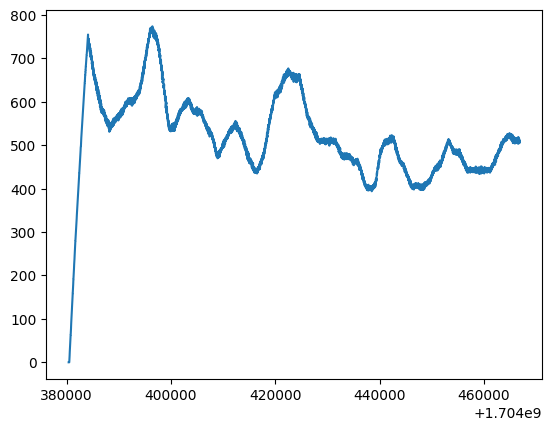

In [85]:
lengths = [len(time2movement[time]) for time in times]
import matplotlib.pyplot as plt
plt.plot(times,lengths)

In [88]:
time2movement[times[1000]]

inter_no  phas_A  phas_B  move_A  move_B  start_unix
0         206       1       1       8       4  1704381841
1         206       2       2      17      18  1704381841
2         206       3       3       8       4  1704381841
3         206       4       4      17      18  1704381841
4         211       1       1       6       2  1704381845
..        ...     ...     ...     ...     ...         ...
643       206       3       3       8       4  1704385320
644       211       1       1       6       2  1704385325
645       211       2       2      17      18  1704385325
646       177       1       1       8       4  1704385350
647       177       2       2       7       3  1704385350

[648 rows x 6 columns]

In [ ]:
J=0
for time in times:
    # 1. 상태 테이블 조회해서 전체 데이터중 필요데이터(교차로번호, A링 현시번호, A링 이동류번호, B링 현시번호, B링 이동류번호)만 수집 : A
    move = time2move[time]
    # 2. 이력 테이블 조회해서 교차로별로 유닉스시간 최대인 데이터(교차로변호, 종료유닉스타임)만 수집 : B
    recent_histories = [group.iloc[-1:] for _, group in history[history['end_unix'] < time].groupby('inter_no')]
    if not recent_histories:
        recent_history = pd.DataFrame({'inter_no':[], 'end_unix':[]})
    else:
        recent_history = pd.concat(recent_histories)
    recent_unix = recent_history[['inter_no', 'end_unix']]
    # 3. 상태 테이블 조회정보(A)와 이력 테이블 조회정보(B) 조인(키값 : 교차로번호) : C
    move = pd.merge(move, recent_unix, how='left', left_on='inter_no', right_on='inter_no')
    move['end_unix'] = move['end_unix'].fillna(0).astype(int)
    move = move.drop_duplicates()
    # 4. C데이터 프레임에 신규 컬럼(시작 유닉스타임) 생성 후 종료유닉스 타임 값 입력, 종료 유닉스 타임 컬럼 제거
    move = move.rename(columns = {'end_unix':'start_unix'})
    # 5. 이동류 이력정보 READ
    #     - CSV 파일로 서버에 저장된 이동류정보를 읽어옴(파일이 없는 경우에는 데이터가 없는 프레임 D 생성)
    try:
        if isinstance(movement, pd.DataFrame):
            pass
        else:
            movement = pd.DataFrame()
    except NameError:
        movement = pd.DataFrame()
    # 6. 이동류 이력정보 데이터테이블(D)에 C데이터 add
    movement = pd.concat([movement, move])
    # 7. D데이터 프레임에서 중복데이터 제거(교차로번호, 시작 유닉스타임, A링 현시번호, B링 현시번호 같은 행은 제거)
    movement = movement.drop_duplicates(['inter_no','phas_A','phas_B','start_unix'])
    # 8. D데이터 보관 시간 기준시간을 시작 유닉스 타임의 최대값 - 3600을 값으로 산출하고, 보관 시간 기준시간보다 작은 시작 유닉스 타임을 가진 행은 모두 제거(1시간 데이터만 보관)
    movement = movement[movement.start_unix > time - 3600]
    movement = movement.sort_values(by=['start_unix','inter_no','phas_A','phas_B']).reset_index(drop=True)
    if J % 10 == 0:
        print(time)
        # print('recent_unix', len(recent_histories))
        # display(recent_unix)
        # print('move')
        # display(move)
        # print('movement')
        display(movement)
        print(movement.start_unix.max() - movement.start_unix.min())
    J += 1
    if J == 1000:
        break
del movement